#### import library and data

In [1]:
import pandas as pd 
import numpy as np
import scipy.stats

import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
ratings = pd.read_csv('./datasets/ratings_small.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
from datetime import datetime, timezone, timedelta

#01) 파이썬 'datetime' 패키지를 이용해서 현재시간 얻기 : datetime.now() 함수 이용
print(datetime.utcfromtimestamp(964982703))

2000-07-30 18:45:03


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [9]:
len(ratings['userId'].unique())

610

In [10]:
len(ratings['movieId'].unique())

9724

In [11]:
ratings['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [12]:
movies = pd.read_csv('./datasets/movies_small.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
# ratings 와 movies merge

df = pd.merge(ratings, movies , on='movieId', how='inner')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


#### EDA 

In [15]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]

# Check the information of the dataframe
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, 74 to 9615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              134 non-null    object 
 1   mean_rating        134 non-null    float64
 2   number_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


In [16]:
agg_ratings_GT100.sort_values(by='number_of_ratings' , ascending=False).head()

,title,mean_rating,number_of_ratings
3158,Forrest Gump (1994),4.164134,329
7593,"Shawshank Redemption, The (1994)",4.429022,317
6865,Pulp Fiction (1994),4.197068,307
7680,"Silence of the Lambs, The (1991)",4.161290,279
5512,"Matrix, The (1999)",4.192446,278


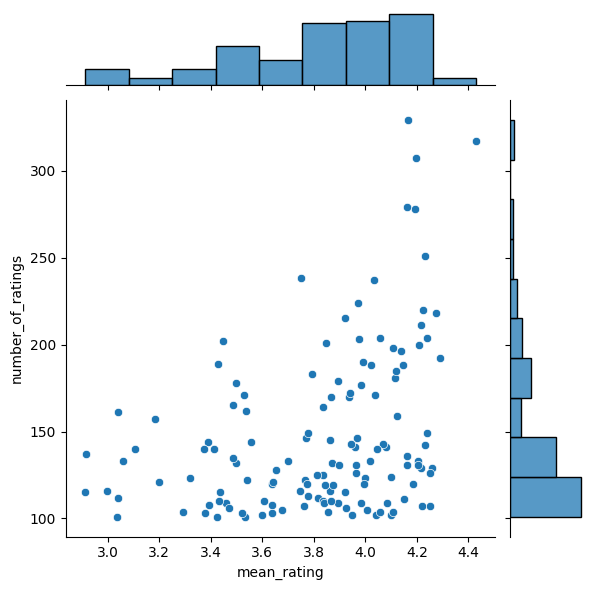

In [17]:
# visualization

sns.jointplot(x='mean_rating', y='number_of_ratings' , data=agg_ratings_GT100)

In [18]:
# df 와 agg_ratings_GT100 merge

df_G100 = pd.merge(df, agg_ratings_GT100 , on='title', how='inner')
df_G100.head()

,userId,movieId,rating,timestamp,title,genres,mean_rating,number_of_ratings
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215


In [19]:
df_G100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19788 entries, 0 to 19787
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   userId             19788 non-null  int64  
 1   movieId            19788 non-null  int64  
 2   rating             19788 non-null  float64
 3   timestamp          19788 non-null  int64  
 4   title              19788 non-null  object 
 5   genres             19788 non-null  object 
 6   mean_rating        19788 non-null  float64
 7   number_of_ratings  19788 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 1.2+ MB


In [20]:
len(df_G100['userId'].unique())

597

In [21]:
len(df_G100['movieId'].unique())

134

#### index= movie title , columns = userId, values = ratings dataframe

In [22]:
matrix = df_G100.pivot_table(index='title', columns='userId', values='rating')
matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,5.0,NaN,3.0,NaN,4.5
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,2.0,NaN,NaN,NaN,3.5,NaN,3.0
Aladdin (1992),NaN,NaN,NaN,4.0,4.0,5.0,3.0,NaN,NaN,4.0,...,NaN,NaN,NaN,3.0,3.5,NaN,NaN,3.0,NaN,NaN
Alien (1979),4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,4.0,3.0,4.0,NaN,4.5
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,3.5,NaN,4.5,NaN,5.0


In [23]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, 2001: A Space Odyssey (1968) to X-Men (2000)
Columns: 597 entries, 1 to 610
dtypes: float64(597)
memory usage: 626.0+ KB


#### 유사도 분석
* 영화 아이템의 평정 유사도 분석

In [32]:
matrix.fillna(0).head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,4.5
Ace Ventura: Pet Detective (1994),0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,3.5,0.0,3.0
Aladdin (1992),0.0,0.0,0.0,4.0,4.0,5.0,3.0,0.0,0.0,4.0,...,0.0,0.0,0.0,3.0,3.5,0.0,0.0,3.0,0.0,0.0
Alien (1979),4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,4.0,3.0,4.0,0.0,4.5
Aliens (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,3.5,0.0,4.5,0.0,5.0


In [37]:
# cosine_similarity 분석
# class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=None)[source]

cosim = cosine_similarity(matrix.fillna(0))
cos_item_similiarity = pd.DataFrame(data=cosim  , index=matrix.index,  columns=matrix.index)

In [38]:
cos_item_similiarity.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),1.000000,0.271807,0.266670,0.569947,0.563665,0.310194,0.450858,0.336402,0.346073,0.569111,...,0.307972,0.443462,0.443564,0.207217,0.258914,0.394586,0.293710,0.209060,0.301007,0.390909
Ace Ventura: Pet Detective (1994),0.271807,1.000000,0.583814,0.289795,0.260504,0.253664,0.295132,0.297858,0.329115,0.244806,...,0.583659,0.358235,0.464536,0.379436,0.219916,0.361444,0.263281,0.523188,0.354519,0.316785
Aladdin (1992),0.266670,0.583814,1.000000,0.349844,0.330907,0.196449,0.353335,0.298202,0.334279,0.258810,...,0.599906,0.408679,0.429238,0.420645,0.294112,0.387548,0.275932,0.502872,0.455531,0.417243
Alien (1979),0.569947,0.289795,0.349844,1.000000,0.773600,0.330537,0.524065,0.386448,0.367893,0.511868,...,0.389492,0.426868,0.476632,0.294272,0.270866,0.434155,0.325394,0.288316,0.384847,0.484586
Aliens (1986),0.563665,0.260504,0.330907,0.773600,1.000000,0.273812,0.480061,0.344400,0.346839,0.475215,...,0.403912,0.374856,0.461290,0.270506,0.249825,0.420826,0.293190,0.235292,0.375540,0.449982


In [39]:
cos_item_similiarity['2001: A Space Odyssey (1968)']

title
2001: A Space Odyssey (1968)                  1.000000
Ace Ventura: Pet Detective (1994)             0.271807
Aladdin (1992)                                0.266670
Alien (1979)                                  0.569947
Aliens (1986)                                 0.563665
                                                ...   
Usual Suspects, The (1995)                    0.394586
WALL·E (2008)                                 0.293710
Waterworld (1995)                             0.209060
Willy Wonka & the Chocolate Factory (1971)    0.301007
X-Men (2000)                                  0.390909
Name: 2001: A Space Odyssey (1968), Length: 134, dtype: float64

In [40]:
# 피어슨 상관분석을 통한 유사도 분석
# DataFrame.corr(method='pearson', min_periods=1, numeric_only=False)
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)
# matrix_norm.head()
item_similiarity = matrix_norm.T.corr()

In [41]:
item_similiarity['2001: A Space Odyssey (1968)']

title
2001: A Space Odyssey (1968)                  1.000000
Ace Ventura: Pet Detective (1994)            -0.036319
Aladdin (1992)                                0.017446
Alien (1979)                                  0.318523
Aliens (1986)                                 0.317386
                                                ...   
Usual Suspects, The (1995)                    0.245279
WALL·E (2008)                                 0.100172
Waterworld (1995)                            -0.447306
Willy Wonka & the Chocolate Factory (1971)    0.087803
X-Men (2000)                                 -0.123862
Name: 2001: A Space Odyssey (1968), Length: 134, dtype: float64

In [42]:
matrix_norm.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,0.105505,NaN,NaN,NaN,...,NaN,NaN,1.105505,NaN,NaN,1.105505,NaN,-0.894495,NaN,0.605505
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,-0.040373,-0.040373,NaN,NaN,NaN,NaN,...,NaN,-1.040373,NaN,-1.040373,NaN,NaN,NaN,0.459627,NaN,-0.040373
Aladdin (1992),NaN,NaN,NaN,0.20765,0.207650,1.207650,-0.792350,NaN,NaN,0.20765,...,NaN,NaN,NaN,-0.792350,-0.29235,NaN,NaN,-0.792350,NaN,NaN
Alien (1979),0.030822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.030822,NaN,NaN,0.030822,-0.969178,0.030822,NaN,0.530822
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.035714,NaN,NaN,-0.464286,NaN,0.535714,NaN,1.035714


#### 하나의 영화에 대해서 user의 평점을 예측
1. user1을 기준으로 등급을 매긴 영화목록을 만든다.
2. user1 본영화 평점과 American Pie (1999) 유사도등을 구해서 랭킹을 매긴다.
3. 탑 10을 선택한다.
4. 유사도 점수의 가중 평균과 user1등을 사용하여 예측등급을 계산한다.


In [51]:
# user1 이용
picked_user = 1

# American Pie (1999)을 이용
picked_movie = 'American Pie (1999)'

#user 1이 본 영화
picked_userid_watched = pd.DataFrame(matrix_norm[picked_user].dropna(axis=0, how='all')).sort_values(by=1, ascending=False).reset_index()
picked_userid_watched = picked_userid_watched.rename(columns={1: 'rating'})

In [52]:
picked_userid_watched.head()

,title,rating
0,Dumb & Dumber (Dumb and Dumber) (1994),1.939850
1,Indiana Jones and the Temple of Doom (1984),1.361111
2,X-Men (2000),1.300752
3,E.T. the Extra-Terrestrial (1982),1.233607
4,Ghostbusters (a.k.a. Ghost Busters) (1984),1.225000


In [84]:
# American Pie (1999) 유사한 영화 
picked_movie_sim_score = pd.DataFrame(item_similiarity[picked_movie]).reset_index().rename(columns={picked_movie:'sim_score'})

In [85]:
picked_movie_sim_score.head()

,title,sim_score
0,2001: A Space Odyssey (1968),-0.447306
1,Ace Ventura: Pet Detective (1994),0.176155
2,Aladdin (1992),0.065342
3,Alien (1979),0.119849
4,Aliens (1986),-0.014274


In [62]:
# picked_userid_watched 와 picked_movie_sim_score merge

picked_userid_watched_sim = pd.merge(picked_userid_watched, picked_movie_sim_score , on='title', how='inner')
picked_userid_watched_sim = picked_userid_watched_sim.sort_values(by='sim_score', ascending=False)[:10]
picked_userid_watched_sim.head()

,title,rating,sim_score
52,Mission: Impossible (1996),-0.537037,0.510888
47,Twister (1996),-0.321138,0.476518
16,Star Wars: Episode I - The Phantom Menace (1999),0.892857,0.443614
10,"Fugitive, The (1993)",1.007895,0.442128
19,"Green Mile, The (1999)",0.851351,0.429560


In [65]:
predict_rating = round(np.average(picked_userid_watched_sim['rating'] ,weights=picked_userid_watched_sim["sim_score"] ) , 6)

In [66]:
predict_rating

0.313184

#### Movie Recommandation
1. 대상유저가 못본 영화 목록 만든다.
2. 안본 영화에 predict_rating 값을 구한다.
3. 높은 점수 순으로 상위 10개 영화를 추천한다.

In [78]:
# 보지 못한 영화 
picked_df = pd.DataFrame(matrix_norm[1].isna()).reset_index()
picked_userid_unwatched = picked_df[picked_df[1]==True]['title'].values.tolist()

In [79]:
picked_userid_unwatched

['2001: A Space Odyssey (1968)',
 'Ace Ventura: Pet Detective (1994)',
 'Aladdin (1992)',
 'Aliens (1986)',
 "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",
 'American Pie (1999)',
 'Apollo 13 (1995)',
 'Austin Powers: The Spy Who Shagged Me (1999)',
 'Babe (1995)',
 'Batman Begins (2005)',
 'Batman Forever (1995)',
 'Beautiful Mind, A (2001)',
 'Beauty and the Beast (1991)',
 'Blade Runner (1982)',
 'Bourne Identity, The (2002)',
 'Breakfast Club, The (1985)',
 'Catch Me If You Can (2002)',
 'Cliffhanger (1993)',
 'Clueless (1995)',
 'Crimson Tide (1995)',
 'Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)',
 'Dark Knight, The (2008)',
 'Departed, The (2006)',
 'Die Hard (1988)',
 'Die Hard: With a Vengeance (1995)',
 'Donnie Darko (2001)',
 'Eternal Sunshine of the Spotless Mind (2004)',
 "Ferris Bueller's Day Off (1986)",
 'Fifth Element, The (1997)',
 'Finding Nemo (2003)',
 'Firm, The (1993)',
 'Four Weddings and a Funeral (1994)',
 'Ghost (1990)',
 'Godfather, The 

In [82]:
# 안본영화에 대한  predict_rating 으로 merge

rating_prediction = {}

for picked_movie in picked_userid_unwatched:
    picked_movie_sim_score = item_similiarity[picked_movie].reset_index().rename(columns={picked_movie:'sim_score'})
    picked_userid_watched_sim = pd.merge(picked_userid_watched, picked_movie_sim_score , on='title', how='inner')
    picked_userid_watched_sim = picked_userid_watched_sim.sort_values(by='sim_score', ascending=False)[:10]
    predict_rating = round(np.average(picked_userid_watched_sim['rating'] ,weights=picked_userid_watched_sim["sim_score"] ) , 6)
    
    rating_prediction[picked_movie] = predict_rating
    
    
    
    

In [88]:
import operator
sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:10]

[('Austin Powers: The Spy Who Shagged Me (1999)', 0.991166),
 ('Lord of the Rings: The Return of the King, The (2003)', 0.873138),
 ("There's Something About Mary (1998)", 0.795021),
 ('Fifth Element, The (1997)', 0.756015),
 ('Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)', 0.744494),
 ('Home Alone (1990)', 0.740627),
 ('Godfather, The (1972)', 0.68168),
 ('Terminator 2: Judgment Day (1991)', 0.668194),
 ('Truman Show, The (1998)', 0.668172),
 ('Beautiful Mind, A (2001)', 0.665253)]

In [86]:
rating_prediction.items()

dict_items([('2001: A Space Odyssey (1968)', 0.590347), ('Ace Ventura: Pet Detective (1994)', 0.296757), ('Aladdin (1992)', 0.658992), ('Aliens (1986)', 0.327327), ("Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)", 0.453496), ('American Pie (1999)', 0.313184), ('Apollo 13 (1995)', 0.640587), ('Austin Powers: The Spy Who Shagged Me (1999)', 0.991166), ('Babe (1995)', 0.489272), ('Batman Begins (2005)', 0.650354), ('Batman Forever (1995)', 0.216289), ('Beautiful Mind, A (2001)', 0.665253), ('Beauty and the Beast (1991)', 0.439208), ('Blade Runner (1982)', 0.46937), ('Bourne Identity, The (2002)', 0.592828), ('Breakfast Club, The (1985)', 0.379866), ('Catch Me If You Can (2002)', 0.613671), ('Cliffhanger (1993)', 0.147104), ('Clueless (1995)', 0.287108), ('Crimson Tide (1995)', -0.005331), ('Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)', 0.744494), ('Dark Knight, The (2008)', 0.491468), ('Departed, The (2006)', 0.565131), ('Die Hard (1988)', 0.260045), ('Die Hard: With a 

In [81]:
item_similiarity[picked_movie].reset_index().rename(columns={picked_movie:'sim_score'})

,title,sim_score
0,2001: A Space Odyssey (1968),0.011490
1,Ace Ventura: Pet Detective (1994),0.173855
2,Aladdin (1992),0.367076
3,Alien (1979),-0.006804
4,Aliens (1986),0.076674
...,...,...
129,"Usual Suspects, The (1995)",0.280924
130,WALL·E (2008),0.060699
131,Waterworld (1995),0.180433
132,Willy Wonka & the Chocolate Factory (1971),0.051963
